## Training a Churn Prediction Model
### Objective
The objective of this notebook is to train a binary classification model that can predict churn and hence, automate client classification.

### 1. Exploratory Data Analysis

In [6]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="ticks", palette="pastel")

def remove_outliers(df, col: str):
    q3 = np.quantile(df[col], 0.75)
    q1 = np.quantile(df[col], 0.25)
    l_lmt = q1 - 1.5 * (q3 - q1)
    u_lmt = q3 + 1.5 * (q3 - q1)
    return df[(df[col] >= l_lmt) & (df[col] <= u_lmt)].copy()
    
#Read Sample Dataset
raw_df = pd.read_csv('../data/churn.csv')
raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
#Check number of records and columns
print(raw_df.shape)

(7043, 21)


In [8]:
#Check of missing values
raw_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7043 non-null   object 
 1   gender              7043 non-null   object 
 2   SeniorCitizen       7043 non-null   int64  
 3   Partner             7043 non-null   object 
 4   Dependents          7043 non-null   object 
 5   tenure              7043 non-null   int64  
 6   PhoneService        7043 non-null   object 
 7   MultipleLines       7043 non-null   object 
 8   InternetService     7043 non-null   object 
 9   OnlineSecurity      7043 non-null   object 
 10  OnlineBackup        7043 non-null   object 
 11  DeviceProtection    7043 non-null   object 
 12  TechSupport         7043 non-null   object 
 13  StreamingTV         7043 non-null   object 
 14  StreamingMovies     7043 non-null   object 
 15  Contract            7043 non-null   object 
 16  Paperl

In [9]:
raw_df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.000000,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500,NaN


In [10]:
def log_txf(df, cols: list):
    for col in cols:
        df['log_'+col] = np.log(df[col]+1)
    return df

raw_df = log_txf(raw_df, ['tenure','MonthlyCharges','TotalCharges'])
raw_df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,log_tenure,log_MonthlyCharges,log_TotalCharges
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043.000000,7032.000000,7043,7043.000000,7043.000000,7032.000000
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,2,4,NaN,NaN,2,NaN,NaN,NaN
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,NaN,NaN,No,NaN,NaN,NaN
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,2785,3875,4171,2365,NaN,NaN,5174,NaN,NaN,NaN
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,64.761692,2283.300441,NaN,3.036873,4.043347,6.943387
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,30.090047,2266.771362,NaN,1.155510,0.580288,1.546438
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,2.957511,2.985682
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.500000,401.450000,NaN,2.302585,3.597312,5.997571
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN,3.401197,4.267597,7.243138
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,89.850000,3794.737500,NaN,4.025352,4.509210,8.241634


/var/folders/wf/hnx474j97s9b5yjk45p_kd9w0000gn/T/ipykernel_23387/3762701701.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g = g.set_xticklabels(g.get_xticklabels(), rotation=30)


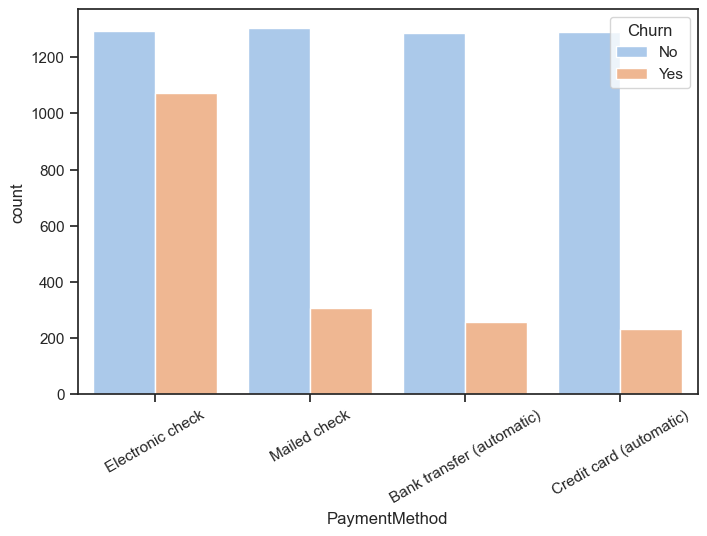

In [12]:
plt.figure(figsize=(8,5))
g = sns.countplot(raw_df, x="PaymentMethod", hue="Churn")
g = g.set_xticklabels(g.get_xticklabels(), rotation=30)

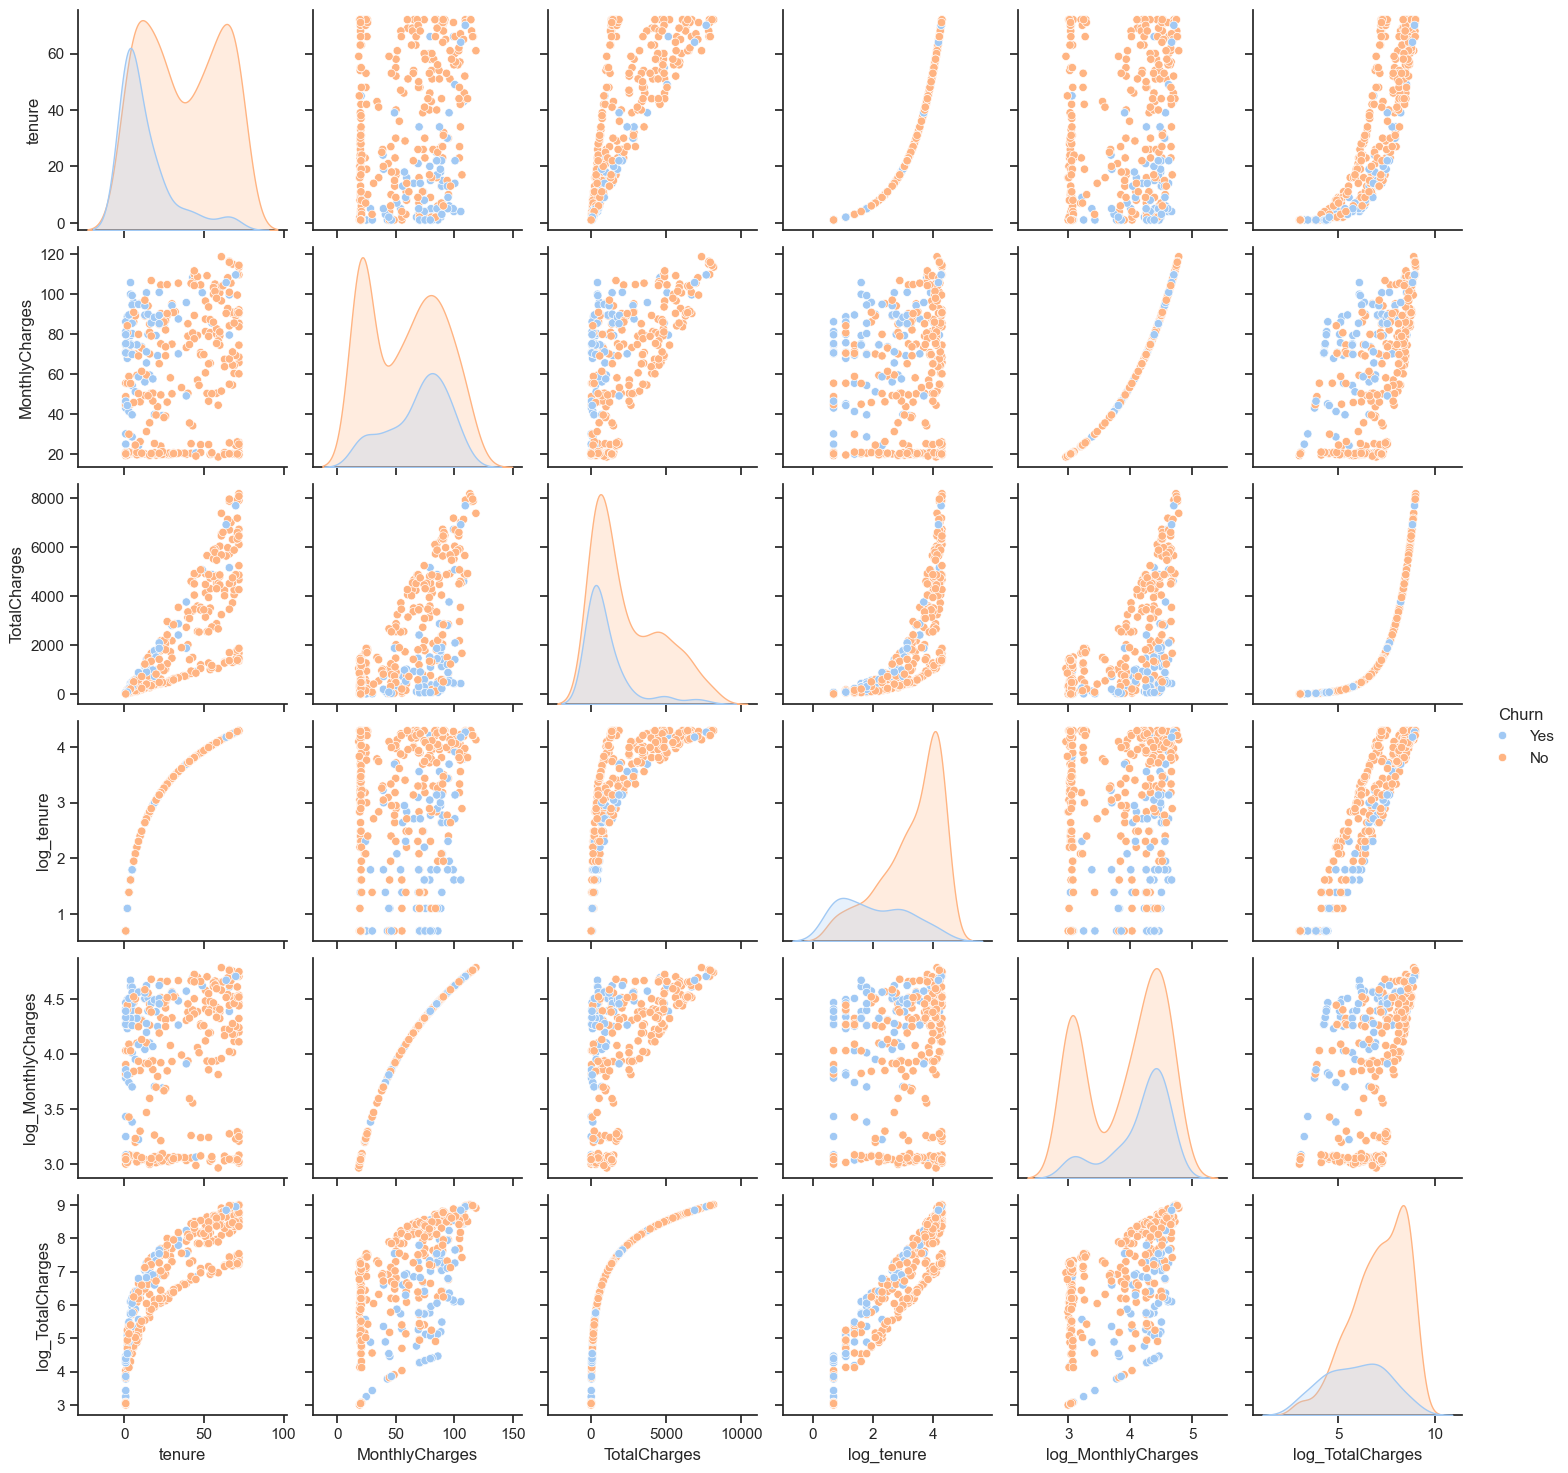

In [13]:
plt_df = raw_df.sample(frac=0.05)
g = sns.pairplot(plt_df[['tenure','MonthlyCharges','TotalCharges','log_tenure',	'log_MonthlyCharges','log_TotalCharges','Churn']], 
                 hue='Churn')

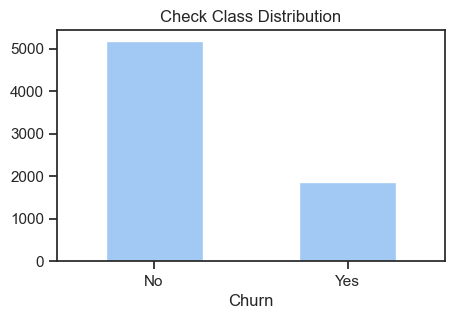

In [14]:
plt.figure(figsize=(5,3))
g = raw_df['Churn'].value_counts().plot.bar(title='Check Class Distribution', rot=0)

### 2. Feature Engineering

In [15]:
# def remap_emp_length(x):
#     if x in ['< 1 year','1 year','2 years']:
#         return 'less_than_3yr'
#     if x in ['3 years','4 years','5 years']:
#         return '3_to_5yr'
#     if x in ['6 years','7 years','8 years','9 years']:
#         return '6_to_9yr'
#     return 'more_than_9yr'

# raw_df['emp_len'] = raw_df['emp_length'].map(remap_emp_length)
# g = sns.countplot(raw_df, x="emp_len", hue="fully_paid")

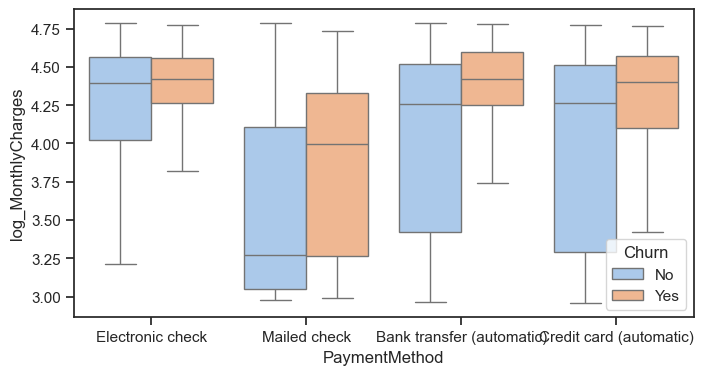

In [16]:
plt.figure(figsize=(8,4))
g = sns.boxplot(x="PaymentMethod", y="log_MonthlyCharges", hue="Churn", data=raw_df, showfliers = False)

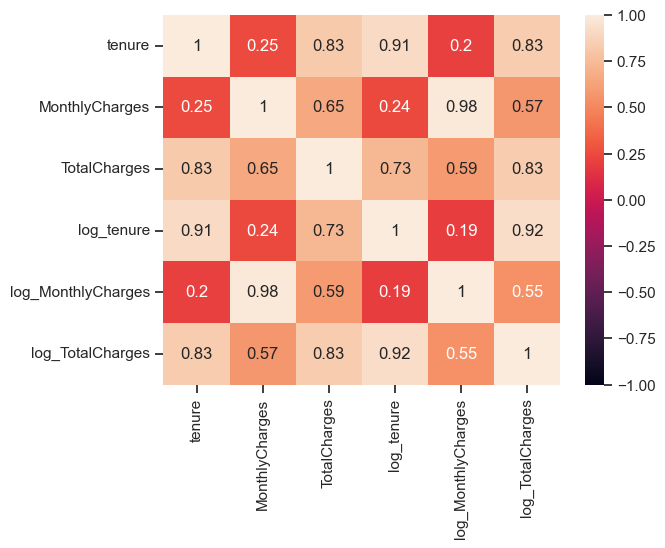

In [17]:
numeric_cols = ['tenure','MonthlyCharges','TotalCharges','log_tenure',	'log_MonthlyCharges','log_TotalCharges']
g = sns.heatmap(raw_df[numeric_cols].corr(), vmin=-1, vmax=1, annot=True)

### 3. Data Preprocessing

In [18]:
#Select features that are discriminatory and uncorrelated
features = ['gender','SeniorCitizen','Partner','Dependents','log_tenure','PhoneService','MultipleLines',
            'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
            'StreamingMovies','Contract','PaperlessBilling','PaymentMethod','log_MonthlyCharges','log_TotalCharges']

numeric_features = ['log_tenure','log_MonthlyCharges','log_TotalCharges']

categorical_features =  ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
                         'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                         'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

label = 'Churn'

numeric_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

dat = preprocessor.fit_transform(raw_df)
new_cols = numeric_features + \
list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

trf_df = pd.DataFrame(dat, columns=new_cols)
trf_df.head()

,log_tenure,log_MonthlyCharges,log_TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.161555,0.258016,0.072892,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.828664,0.602917,0.749358,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.256059,0.572840,0.280590,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.892362,0.443484,0.745063,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.256059,0.719396,0.335724,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### 4. Modeling
#### 4.1 Train-Test Split

In [26]:
raw_df.dropna(how='any', inplace=True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(raw_df[features], \
                                                    raw_df[label], \
                                                    test_size=0.2, \
                                                    random_state=0)
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,log_tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,log_MonthlyCharges,log_TotalCharges
2964,Male,0,Yes,No,3.218876,Yes,Yes,DSL,Yes,No,No,Yes,No,No,One year,Yes,Electronic check,4.083452,7.206303
5113,Female,0,Yes,Yes,4.276666,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),4.741884,9.007955
5363,Male,0,Yes,Yes,4.262680,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,3.271468,7.447839
5074,Female,0,No,Yes,3.912023,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),3.017983,6.826871
156,Female,0,No,No,3.135494,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),4.444414,7.508211


#### 4.2 Train Classifier

In [28]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=4, 
                                       class_weight = "balanced",
                                       n_jobs=2)

clf = Pipeline(steps=[("preprocessor", preprocessor),\
                      ("binary_classifier", random_forest)]
              )

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['log_tenure',
                                                   'log_MonthlyCharges',
                                                   'log_TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('binary_classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        n_jobs=2))])

### 5. Evaluation

In [29]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          No       0.92      0.71      0.80      1038
         Yes       0.50      0.82      0.62       369

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.74      0.75      1407

